In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
matches = pd.read_csv("originalDataset.csv")
matches = matches.iloc[:997]

In [3]:
#Find Only Matches with World Cup 2019 Teams
teams = ["England", "South Africa", "India" , "Australia", "New Zealand" ,
         "Bangladesh" , "Pakistan", "Sri Lanka" , "Afghanistan", "West Indies"]
notTeams = []
for i in range(0,997):
    if(not (matches.loc[i,"Team1"] in teams) or (not (matches.loc[i,"Team2"] in teams))):
        notTeams.append(i)
wcMatches = matches.drop(notTeams)

In [4]:
#Calculation of Team v Team win rates
winRates = np.zeros((10,10))
for i in range(0,10):
    #print(teams[i] + " Win Rates:")
    for j in range(0,10):
        if(not (i == j)):
            iCount = 0
            jCount = 0
            for index, row in wcMatches.iterrows():
                if((row['Team1'] == teams[i] and row['Team2'] == teams[j]) or 
                   (row["Team2"] == teams[i] and row["Team1"] == teams[j])):
                    if(row["Winner"] == teams[i]):
                        iCount = iCount + 1
                    if(row["Winner"] == teams[j]):
                        jCount = jCount + 1
            if(iCount + jCount > 0):
                winRates[i][j] = round(100 * iCount/(iCount + jCount),2)
                #print("Win Rate of " + teams[i] + " vs " + teams[j] +  ": " + str(round(100 * iCount/(iCount + jCount) ,2)) + "%")
            else:
                winRates[i][j] = -10.00
                #print("Win Rate of " + teams[i] + " vs " + teams[j] +  ": 50.0%" )
        else:
            winRates[i][j] = -10.00
winRatesDF = pd.DataFrame(winRates, index = teams, columns=teams)
winRatesDF

,England,South Africa,India,Australia,New Zealand,Bangladesh,Pakistan,Sri Lanka,Afghanistan,West Indies
England,-10.00,57.14,39.13,40.00,57.14,66.67,73.68,43.48,100.0,92.31
South Africa,42.86,-10.00,52.63,55.56,61.11,71.43,57.14,65.00,-10.0,80.00
India,60.87,47.37,-10.00,47.83,57.89,76.92,63.64,69.44,100.0,72.00
Australia,60.00,44.44,52.17,-10.00,56.25,100.00,83.33,53.85,100.0,82.35
New Zealand,42.86,38.89,42.11,43.75,-10.00,47.06,66.67,50.00,100.0,40.00
Bangladesh,33.33,28.57,23.08,0.00,52.94,-10.00,30.00,23.08,60.0,33.33
Pakistan,26.32,42.86,36.36,16.67,33.33,70.00,-10.00,60.61,100.0,66.67
Sri Lanka,56.52,35.00,30.56,46.15,50.00,76.92,39.39,-10.00,100.0,77.78
Afghanistan,0.00,-10.00,0.00,0.00,0.00,40.00,0.00,0.00,-10.0,50.00
West Indies,7.69,20.00,28.00,17.65,60.00,66.67,33.33,22.22,50.0,-10.00


In [5]:
#Calculation of Team v Team win rates
winRates = np.zeros((10,10))
for i in range(0,10):
    #print(teams[i] + " Win Rates:")
    for j in range(0,10):
        if(not (i == j)):
            iCount = 0
            jCount = 0
            for index, row in wcMatches.iterrows():
                if((row['Team1'] == teams[i] and row['Team2'] == teams[j]) or 
                   (row["Team2"] == teams[i] and row["Team1"] == teams[j])):
                    if(row["Winner"] == teams[i]):
                        iCount += int(row["Year"]) - 2009
                    if(row["Winner"] == teams[j]):
                        jCount += int(row["Year"]) - 2009
            if(iCount + jCount > 0):
                winRates[i][j] = round(100 * iCount/(iCount + jCount),2)
                #print("Win Rate of " + teams[i] + " vs " + teams[j] +  ": " + str(round(100 * iCount/(iCount + jCount) ,2)) + "%")
            else:
                winRates[i][j] = -10.00
                #print("Win Rate of " + teams[i] + " vs " + teams[j] +  ": 50.0%" )
        else:
            winRates[i][j] = -10.00
winRatesDF = pd.DataFrame(winRates, index = teams, columns=teams)
winRatesDF

,England,South Africa,India,Australia,New Zealand,Bangladesh,Pakistan,Sri Lanka,Afghanistan,West Indies
England,-10.00,54.55,40.62,37.31,58.33,62.79,72.62,45.63,100.0,93.67
South Africa,45.45,-10.00,49.30,62.11,60.82,72.73,52.00,74.04,-10.0,68.75
India,59.38,50.70,-10.00,46.72,50.00,72.73,58.33,78.20,100.0,72.73
Australia,62.69,37.89,53.28,-10.00,50.65,100.00,83.12,61.05,100.0,79.69
New Zealand,41.67,39.18,50.00,49.35,-10.00,54.29,74.60,61.29,100.0,47.50
Bangladesh,37.21,27.27,27.27,0.00,45.71,-10.00,50.00,26.79,62.5,28.95
Pakistan,27.38,48.00,41.67,16.88,25.40,50.00,-10.00,65.56,100.0,68.67
Sri Lanka,54.37,25.96,21.80,38.95,38.71,73.21,34.44,-10.00,100.0,75.00
Afghanistan,0.00,-10.00,0.00,0.00,0.00,37.50,0.00,0.00,-10.0,50.00
West Indies,6.33,31.25,27.27,20.31,52.50,71.05,31.33,25.00,50.0,-10.00


In [6]:
#Make data more uniform
winRatesDF = winRatesDF.replace(-10,'-')
winRatesDFStrings = winRatesDF.replace(100, "100.00")
winRatesDFStrings = winRatesDFStrings.replace(40, "40.00")
winRatesDFStrings = winRatesDFStrings.replace(0, "0.00")
winRatesDFStrings = winRatesDFStrings.replace(50, "50.00")
winRatesDFStrings = winRatesDFStrings.replace(60, "60.00")
winRatesDFStrings = winRatesDFStrings.replace(65, "65.00")
winRatesDFStrings = winRatesDFStrings.replace(72, "72.00")
winRatesDFStrings = winRatesDFStrings.replace(20, "20.00")
winRatesDFStrings = winRatesDFStrings.replace(35, "35.00")
winRatesDFStrings = winRatesDFStrings.replace(30, "30.00")
winRatesDFStrings = winRatesDFStrings.replace(70, "70.00")
winRatesDFStrings = winRatesDFStrings.replace(80, "80.00")
winRatesDFStrings = winRatesDFStrings.replace(28, "28.00")
winRatesDFStrings = winRatesDFStrings.replace(50.7, "50.70")
winRatesDFStrings = winRatesDFStrings.replace(48, "48.00")
winRatesDFStrings = winRatesDFStrings.replace(21.8, "21.80")
winRatesDFStrings = winRatesDFStrings.replace(25.4, "25.40")
winRatesDFStrings = winRatesDFStrings.replace(52.5, "52.50")
winRatesDFStrings = winRatesDFStrings.replace(37.5, "37.50")
winRatesDFStrings = winRatesDFStrings.replace(52, "52.00")
winRatesDFStrings = winRatesDFStrings.replace(25, "25.00")
winRatesDFStrings = winRatesDFStrings.replace(78.2, "78.20")
winRatesDFStrings = winRatesDFStrings.replace(62.5, "62.50")
winRatesDFStrings = winRatesDFStrings.replace(47.5, "47.50")
winRatesDFStrings = winRatesDFStrings.replace(75, "75.00")
winRatesDFStrings = winRatesDFStrings.replace(74.6, "74.60")
winRatesDFStrings = winRatesDFStrings.replace(49.3, "49.30")



winRatesDFStrings

,England,South Africa,India,Australia,New Zealand,Bangladesh,Pakistan,Sri Lanka,Afghanistan,West Indies
England,-,54.55,40.62,37.31,58.33,62.79,72.62,45.63,100.00,93.67
South Africa,45.45,-,49.30,62.11,60.82,72.73,52.00,74.04,-,68.75
India,59.38,50.70,-,46.72,50.00,72.73,58.33,78.20,100.00,72.73
Australia,62.69,37.89,53.28,-,50.65,100.00,83.12,61.05,100.00,79.69
New Zealand,41.67,39.18,50.00,49.35,-,54.29,74.60,61.29,100.00,47.50
Bangladesh,37.21,27.27,27.27,0.00,45.71,-,50.00,26.79,62.50,28.95
Pakistan,27.38,48.00,41.67,16.88,25.40,50.00,-,65.56,100.00,68.67
Sri Lanka,54.37,25.96,21.80,38.95,38.71,73.21,34.44,-,100.00,75.00
Afghanistan,0.00,-,0.00,0.00,0.00,37.50,0.00,0.00,-,50.00
West Indies,6.33,31.25,27.27,20.31,52.50,71.05,31.33,25.00,50.00,-


In [7]:
# wcMatches
# i = 1
# for index, row in wcMatches.iterrows():
#     row["MatchID"] = i
#     i+=1

In [8]:
realMatches = pd.read_csv("matchData.csv")

In [9]:
realMatches.head()

,Winner,MatchID,Team1,Team2,Margin,Year
0,Sri Lanka,0,Bangladesh,Sri Lanka,7 wickets,2010
1,Sri Lanka,1,India,Sri Lanka,5 wickets,2010
2,India,2,Bangladesh,India,6 wickets,2010
3,Sri Lanka,3,Bangladesh,Sri Lanka,9 wickets,2010
4,India,4,India,Sri Lanka,8 wickets,2010


In [10]:
#Add historical winrate records between team1 and team2
winrates = []
for index, row in realMatches.iterrows():
    Team1 = row["Team1"]
    Team2 = row["Team2"]
    count1 = 0
    count2 = 0
    j=1
    for i in range(0,row["MatchID"]):
        if((realMatches["Team1"][i] == Team1 and realMatches["Team2"][i] == Team2)
          or (realMatches["Team1"][i] == Team2 and realMatches["Team2"][i] == Team1)):
            if(realMatches["Winner"][i] == Team1):
                count1 += realMatches["Year"][i] - 2009
            else:
                count2 += realMatches["Year"][i] - 2009
            j*=1.5
    if(count1 + count2 > 0):
        #print(round(count1/(count1+count2),2))
        winrates.append(round(count1/(count1+count2),2))
    else:
        winrates.append(0.50)
realMatches["WinRateVsTeam"] = winrates

In [11]:
#historical overall winrates for team1
winratesT1 = []
for index, row in realMatches.iterrows():
    Team1 = row["Team1"]
    Team2 = row["Team2"]
    count1 = 0
    count2 = 0
    j=1
    for i in range(0,row["MatchID"]):
        if(realMatches["Team1"][i] == Team1  or realMatches["Team2"][i] == Team1):
            if(realMatches["Winner"][i] == Team1):
                count1 += realMatches["Year"][i] - 2009
            else:
                count2 += realMatches["Year"][i] - 2009
    if(count1 + count2 > 0):
        #print(round(count1/(count1+count2),2))
        winratesT1.append(round(count1/(count1+count2),2))
    else:
        winratesT1.append(0.50)
realMatches["T1WinRate"] = winratesT1

In [12]:
#historical overall winrates for team2
winratesT2 = []
for index, row in realMatches.iterrows():
    Team1 = row["Team1"]
    Team2 = row["Team2"]
    count1 = 0
    count2 = 0
    j=1
    for i in range(0,row["MatchID"]):
        if(realMatches["Team1"][i] == Team2  or realMatches["Team2"][i] == Team2):
            if(realMatches["Winner"][i] == Team2):
                count1 += realMatches["Year"][i] - 2009
            else:
                count2 += realMatches["Year"][i] - 2009
    if(count1 + count2 > 0):
        #print(round(count1/(count1+count2),2))
        winratesT2.append(round(count1/(count1+count2),2))
    else:
        winratesT2.append(0.50)
realMatches["T2WinRate"] = winratesT2

In [13]:
#Boolean describing units of margin of victory (runs or wickets)
t2Win = []
for index,row in realMatches.iterrows():
    if(isinstance(row["Margin"],float)):
        t2Win.append(0)
    elif(row["Margin"].split()[-1] == "wickets"):
        t2Win.append(1)
    else:
        t2Win.append(0)
realMatches["Team2Wins"] = t2Win

In [14]:
realMatches = realMatches.rename({"Team2Wins" : "WinByWickets"},axis="columns")

In [15]:
#Margin to float
margin = []
for index,row in realMatches.iterrows():
    if(not isinstance(row["Margin"],float)):
        margin.append(row["Margin"].split()[0])
    else:
        margin.append(0)
realMatches["Margin"] = margin

In [16]:
xgMatches = realMatches.copy()

In [17]:
xgMatches.head()

,Winner,MatchID,Team1,Team2,Margin,Year,WinRateVsTeam,T1WinRate,T2WinRate,WinByWickets
0,Sri Lanka,0,Bangladesh,Sri Lanka,7,2010,0.5,0.5,0.5,1
1,Sri Lanka,1,India,Sri Lanka,5,2010,0.5,0.5,1.0,1
2,India,2,Bangladesh,India,6,2010,0.5,0.0,0.0,1
3,Sri Lanka,3,Bangladesh,Sri Lanka,9,2010,0.0,0.0,1.0,1
4,India,4,India,Sri Lanka,8,2010,0.0,0.5,1.0,1


In [18]:
#Encode winner as a boolean
i=0
for index,row in xgMatches.iterrows():
    if(row["Winner"] == row["Team1"]):
        xgMatches["Winner"][i] = 0
    elif(row["Winner"] == row["Team2"]):
        xgMatches["Winner"][i] = 1
    i+=1
#xgMatches = xgMatches.drop('ifor', axis = 'columns')
xgMatches.head()

,Winner,MatchID,Team1,Team2,Margin,Year,WinRateVsTeam,T1WinRate,T2WinRate,WinByWickets
0,1,0,Bangladesh,Sri Lanka,7,2010,0.5,0.5,0.5,1
1,1,1,India,Sri Lanka,5,2010,0.5,0.5,1.0,1
2,1,2,Bangladesh,India,6,2010,0.5,0.0,0.0,1
3,1,3,Bangladesh,Sri Lanka,9,2010,0.0,0.0,1.0,1
4,0,4,India,Sri Lanka,8,2010,0.0,0.5,1.0,1


In [19]:
#remove margin of victory and boolean of margin units for winner predictor
xgMatches=xgMatches[:651]
xgMatches = xgMatches.drop("Margin",axis="columns")


In [20]:
xgMatches=xgMatches.drop("WinByWickets",axis="columns")

In [21]:
#stats for each team
teamData = pd.read_csv("teamStatsAdvanced.csv")
teamData = teamData.rename({"Unnamed: 0" : "Team"}, axis="columns")
teamData

,Team,Matches played,Innings batted,Not outs,Highest inns score,Batting average,Batting strike rate,Stumpings made,Runs scored/Innings,Balls faced/Innings,...,Boundary fours/Innings,Boundary sixes/Innings,Catches/Innings,Innings bowled,Bowling average,Economy rate,Bowling strike rate,Balls bowled/Innings,Runs conceded/Innings,Wickets taken/Innings
0,India,1573,110.000000,23.100000,128.800000,40.327000,91.667000,12.700000,324.720405,356.848083,...,29.455556,6.409462,6.599264,59.111111,37.175556,5.110000,42.777778,411.372639,347.582162,11.746992
1,Pakistan,1012,69.909091,10.818182,114.636364,39.550000,85.589091,2.090909,357.770459,419.182396,...,30.656950,4.431474,5.589405,51.375000,35.865000,5.323750,40.600000,375.817792,335.690898,10.001532
2,England,1234,75.000000,11.090909,114.636364,34.098182,91.858182,2.818182,324.464611,348.959827,...,31.030437,7.153610,5.975101,61.500000,38.586250,5.930000,39.275000,366.684240,358.623145,9.681133
3,Afghanistan,848,59.666667,5.555556,104.444444,29.146667,76.084444,2.777778,238.367626,320.249531,...,20.356499,5.242254,3.357003,50.444444,27.538889,4.755556,34.377778,390.091477,299.877785,12.169411
4,Australia,814,67.625000,5.250000,131.750000,39.115000,91.815000,0.375000,283.659426,315.172296,...,26.578815,5.116816,4.135243,39.375000,33.333750,5.348750,37.450000,402.164520,358.059542,11.630773
5,Bangladesh,1343,82.181818,12.090909,102.363636,31.041818,81.051818,4.090909,286.695282,355.424325,...,27.163847,4.703703,4.966758,89.750000,33.177500,5.107500,39.550000,377.296617,321.141103,10.680032
6,New Zealand,1157,86.222222,13.000000,125.111111,35.520000,92.472222,0.777778,264.394001,295.061498,...,23.527136,5.528133,4.456428,55.250000,33.105000,5.426250,36.800000,378.761240,341.118306,10.906928
7,South Africa,1143,101.714286,15.857143,138.714286,48.001429,88.970000,1.142857,258.147887,293.820842,...,23.532812,3.859680,4.598364,57.111111,28.640000,5.077778,33.611111,413.527999,348.316086,13.122426
8,Sri Lanka,1106,58.818182,8.909091,94.909091,28.145455,88.938182,0.181818,259.553490,296.375485,...,23.951830,5.356121,3.922753,72.800000,44.219000,5.530000,47.340000,378.584401,351.577051,8.984971
9,West Indies,878,71.444444,7.444444,117.000000,29.236667,81.802222,1.000000,233.745902,270.228733,...,19.792667,7.141778,4.722404,55.100000,50.865000,5.693000,53.280000,437.073041,413.788636,11.591790


In [22]:
#add stats for team 1 and team 2 to each row
stats = ["MatchCt","TotInnings","NotOuts", "MaxInnScore", "BatAvg","BatStrRate","Stumpings","Run/Inning","BallsFaced/Inning","Hundreds","Fifties","4/Inning","6/Inning",
         "Catch/Inning","BowlInns", "BowlAvg","EconRate","BowlStrRate","BallBowl/Inning","RunConc/Inning","WickTake/Inning"]
teamIndices = ["India" , "Pakistan" , "England", "Afghanistan", "Australia", "Bangladesh", "New Zealand", "South Africa" ,
               "Sri Lanka", "West Indies"]
#teamData = teamData.drop(["Hundreds/Innings","Fifties/Innings"],axis = 'columns')
i = 1
for stat in stats:
    arr = []
    for index,row in xgMatches.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team2"])][i])
    i+=1
    xgMatches[stat + '2'] = arr
    
i = 1
for stat in stats:
    arr = []
    for index,row in xgMatches.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team1"])][i])
    i+=1
    xgMatches[stat + '1'] = arr

In [23]:
#format for xgboost model, removing matchID, encoding team as int between 0-9
basicXGMatches = xgMatches.drop("MatchID",axis = 'columns')
T1 = []
T2 = []
for index,row in basicXGMatches.iterrows():
    T1.append(teamIndices.index(row["Team1"]))
    T2.append(teamIndices.index(row["Team2"]))
basicXGMatches["Team1"] = T1
basicXGMatches["Team2"] = T2

basicXGMatches = basicXGMatches.astype("float64")

In [24]:
basicTrain = basicXGMatches[0:500]
basicTest = basicXGMatches[500:651]

In [25]:
#Train-test split, test on newest data
basicTrainX = basicTrain.loc[:,"Team1": "WickTake/Inning1"]
basicTrainY = basicTrain.loc[:,"Winner"]
basicTestX = basicTest.loc[:,"Team1" : "WickTake/Inning1"]
basicTestY = basicTest.loc[:,"Winner"]

In [26]:
#xgBoost predictor, test for auc score and test error (Best AUC Score = 0.717, Best test error = 21.8%)

xg_reg1 = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.25, learning_rate = 0.007, max_depth = 12, 
                          alpha = 0, n_estimators = 95, subsample = 1, min_child_weight = 2.15, gamma = 0.19)

xg_reg1.fit(basicTrainX,basicTrainY)
preds = xg_reg1.predict(basicTestX)
error = roc_auc_score(basicTestY,preds)

j=0
for i in range(0,len(preds)):
    if (preds[i]>0.5):
        preds[i]=1
    else:
        preds[i]=0
    if(preds[i] != basicTestY.loc[i+500]):
        j+=1
print(error)
print(j)

0.707029702970297
37


In [27]:
# Tune Model Parameters
# param_test1 = {
#     'max_depth':range(5,10,1),
#     'n_estimators': range(80,120,5)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( 
#     learning_rate =0.0075, 
#     n_estimators=90, 
#     max_depth=12,
#     min_child_weight=2.29,
#     gamma=0.29, 
#     subsample=1, 
#     colsample_bytree=0.4,
#     objective= 'binary:logistic', 
#     nthread=16, 
#     scale_pos_weight=1, 
#     seed=42,
#     reg_lambda=0
# ), 
# param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
# gsearch1.fit(basicXGMatches.loc[:,"Team1": "WickTake/Inning1"],basicXGMatches.loc[:,'Winner'])
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [28]:
#Compare Prediction Values with Actual Values
#print(np.mean(basicXGMatches.loc[:,"Winner"]))
for i in range(0,101):
    print(xgMatches["Team1"][i+550] + " " + xgMatches["Team2"][i+550] + " " + str(preds[i]) + " " + str(basicTestY.loc[i+550]))

South Africa Australia 0.0 0.0
Bangladesh Afghanistan 0.0 0.0
South Africa Australia 0.0 0.0
Pakistan West Indies 0.0 0.0
Pakistan West Indies 0.0 0.0
South Africa Australia 0.0 0.0
Bangladesh England 0.0 1.0
South Africa Australia 0.0 0.0
Bangladesh England 0.0 0.0
Bangladesh England 0.0 1.0
South Africa Australia 0.0 0.0
India New Zealand 0.0 0.0
India New Zealand 0.0 1.0
India New Zealand 0.0 0.0
India New Zealand 0.0 1.0
India New Zealand 0.0 0.0
Sri Lanka West Indies 0.0 1.0
Sri Lanka West Indies 0.0 0.0
Australia New Zealand 0.0 0.0
Australia New Zealand 0.0 0.0
Australia New Zealand 0.0 0.0
New Zealand Bangladesh 0.0 0.0
New Zealand Bangladesh 0.0 0.0
New Zealand Bangladesh 0.0 0.0
Australia Pakistan 0.0 0.0
Australia Pakistan 1.0 1.0
India England 1.0 0.0
Australia Pakistan 1.0 0.0
India England 0.0 0.0
Australia Pakistan 1.0 0.0
India England 1.0 1.0
Australia Pakistan 1.0 0.0
South Africa Sri Lanka 1.0 0.0
New Zealand Australia 1.0 0.0
South Africa Sri Lanka 1.0 0.0
South Afr

In [29]:
#All 45 World Cup 2019 Matches
worldCupData = pd.read_csv("WorldCupMatches.csv")

In [30]:
worldCupData["Year"]=2019
worldCupData.head()

,Team1,Team2,Year
0,England,South Africa,2019
1,Pakistan,West Indies,2019
2,New Zealand,Sri Lanka,2019
3,Australia,Afghanistan,2019
4,Bangladesh,South Africa,2019


In [31]:
#adding same stats as before, winrates and team stats
winrates = []
for index, row in worldCupData.iterrows():
    Team1 = row["Team1"]
    Team2 = row["Team2"]
    count1 = 0
    count2 = 0
    j=1
    for i in range(0,651):
        if((realMatches["Team1"][i] == Team1 and realMatches["Team2"][i] == Team2)
          or (realMatches["Team1"][i] == Team2 and realMatches["Team2"][i] == Team1)):
            if(realMatches["Winner"][i] == Team1):
                count1 += realMatches["Year"][i] - 2009
            else:
                count2 += realMatches["Year"][i] - 2009
            j*=1.5
    if(count1 + count2 > 0):
        #print(round(count1/(count1+count2),2))
        winrates.append(round(count1/(count1+count2),2))
    else:
        winrates.append(0.50)
worldCupData["WinRateVsTeam"] = winrates

In [32]:
winratesT1 = []
for index, row in worldCupData.iterrows():
    Team1 = row["Team1"]
    Team2 = row["Team2"]
    count1 = 0
    count2 = 0
    j=1
    for i in range(0,651):
        if(realMatches["Team1"][i] == Team1  or realMatches["Team2"][i] == Team1):
            if(realMatches["Winner"][i] == Team1):
                count1 += realMatches["Year"][i] - 2009
            else:
                count2 += realMatches["Year"][i] - 2009
    if(count1 + count2 > 0):
        #print(round(count1/(count1+count2),2))
        winratesT1.append(round(count1/(count1+count2),2))
    else:
        winratesT1.append(0.50)
worldCupData["T1WinRate"] = winratesT1

In [33]:
winratesT2 = []
for index, row in worldCupData.iterrows():
    Team1 = row["Team1"]
    Team2 = row["Team2"]
    count1 = 0
    count2 = 0
    j=1
    for i in range(0,651):
        if(realMatches["Team1"][i] == Team2  or realMatches["Team2"][i] == Team2):
            if(realMatches["Winner"][i] == Team2):
                count1 += realMatches["Year"][i] - 2009
            else:
                count2 += realMatches["Year"][i] - 2009
    if(count1 + count2 > 0):
        #print(round(count1/(count1+count2),2))
        winratesT2.append(round(count1/(count1+count2),2))
    else:
        winratesT2.append(0.50)
worldCupData["T2WinRate"] = winratesT2

In [34]:
i = 1
for stat in stats:
    arr = []
    for index,row in worldCupData.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team2"])][i])
    i+=1
    worldCupData[stat + '2'] = arr
    
i = 1
for stat in stats:
    arr = []
    for index,row in worldCupData.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team1"])][i])
    i+=1
    worldCupData[stat + '1'] = arr

In [35]:
T1 = []
T2 = []
for index,row in worldCupData.iterrows():
    T1.append(teamIndices.index(row["Team1"]))
    T2.append(teamIndices.index(row["Team2"]))
worldCupData["Team1"] = T1
worldCupData["Team2"] = T2

worldCupData = worldCupData.astype("float64")

In [36]:
worldCupData.head()

,Team1,Team2,Year,WinRateVsTeam,T1WinRate,T2WinRate,MatchCt2,TotInnings2,NotOuts2,MaxInnScore2,...,4/Inning1,6/Inning1,Catch/Inning1,BowlInns1,BowlAvg1,EconRate1,BowlStrRate1,BallBowl/Inning1,RunConc/Inning1,WickTake/Inning1
0,2.0,7.0,2019.0,0.55,0.56,0.61,1143.0,101.714286,15.857143,138.714286,...,31.030437,7.153610,5.975101,61.500,38.58625,5.93000,39.275,366.684240,358.623145,9.681133
1,1.0,9.0,2019.0,0.69,0.46,0.30,878.0,71.444444,7.444444,117.000000,...,30.656950,4.431474,5.589405,51.375,35.86500,5.32375,40.600,375.817792,335.690898,10.001532
2,6.0,8.0,2019.0,0.61,0.52,0.41,1106.0,58.818182,8.909091,94.909091,...,23.527136,5.528133,4.456428,55.250,33.10500,5.42625,36.800,378.761240,341.118306,10.906928
3,4.0,3.0,2019.0,1.00,0.61,0.22,848.0,59.666667,5.555556,104.444444,...,26.578815,5.116816,4.135243,39.375,33.33375,5.34875,37.450,402.164520,358.059542,11.630773
4,5.0,7.0,2019.0,0.27,0.37,0.61,1143.0,101.714286,15.857143,138.714286,...,27.163847,4.703703,4.966758,89.750,33.17750,5.10750,39.550,377.296617,321.141103,10.680032


In [37]:
#Test xgboost model on world cup matches
xg_reg1.fit(basicXGMatches.loc[:,"Team1":"WickTake/Inning1"],basicXGMatches.loc[:,"Winner"])
wcPreds = xg_reg1.predict(worldCupData)
#wcPreds

In [38]:
#Display predicted outcomes
i=0
worldCupGames = pd.read_csv("WorldCupMatches.csv")
print('\033[1m' + "All World Cup Group Stage Match Predictions:" + '\033[0m')    #Bold Print
for index,row in worldCupGames.iterrows():
    if(wcPreds[i]<0.5):
        print(row["Team1"] + " vs " + row["Team2"] + ": Winner = " + row["Team1"])
    else:
        print(row["Team1"] + " vs " + row["Team2"] + ": Winner = " + row["Team2"])
    i+=1
    


All World Cup Group Stage Match Predictions:
England vs South Africa: Winner = England
Pakistan vs West Indies: Winner = Pakistan
New Zealand vs Sri Lanka: Winner = New Zealand
Australia vs Afghanistan: Winner = Australia
Bangladesh vs South Africa: Winner = South Africa
England vs Pakistan: Winner = England
Afghanistan vs Sri Lanka: Winner = Sri Lanka
India vs South Africa: Winner = India
Bangladesh vs New Zealand: Winner = Bangladesh
Australia vs West Indies: Winner = Australia
Pakistan vs Sri Lanka: Winner = Pakistan
England vs Bangladesh: Winner = England
Afghanistan vs New Zealand: Winner = Afghanistan
Australia vs India: Winner = Australia
South Africa vs West Indies: Winner = South Africa
Bangladesh vs Sri Lanka: Winner = Sri Lanka
Australia vs Pakistan: Winner = Australia
India vs New Zealand: Winner = India
England vs West Indies: Winner = England
Australia vs Sri Lanka: Winner = Australia
Afghanistan vs South Africa: Winner = South Africa
India vs Pakistan: Winner = India
Ban

In [39]:
#Predicting Margin of Victory given the predicted winner
marginMatches0 = pd.read_csv("MarginPredictor0.csv")
marginMatches1 = pd.read_csv("MarginPredictor1.csv")

In [40]:
#add team stats
i = 1
for stat in stats:
    arr = []
    for index,row in marginMatches0.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team2"])][i])
    i+=1
    marginMatches0[stat + '2'] = arr
    
i = 1
for stat in stats:
    arr = []
    for index,row in marginMatches0.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team1"])][i])
    i+=1
    marginMatches0[stat + '1'] = arr
    
i = 1
for stat in stats:
    arr = []
    for index,row in marginMatches1.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team2"])][i])
    i+=1
    marginMatches1[stat + '2'] = arr
    
i = 1
for stat in stats:
    arr = []
    for index,row in marginMatches1.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team1"])][i])
    i+=1
    marginMatches1[stat + '1'] = arr

In [41]:
#Run this only once
#encode team as int
T1_0 = []
T2_0 = []
Winner_0 = []
for index,row in marginMatches0.iterrows():
    T1_0.append(teamIndices.index(row["Team1"]))
    T2_0.append(teamIndices.index(row["Team2"]))
    Winner_0.append(teamIndices.index(row["Winner"]))
marginMatches0["Team1"] = T1_0
marginMatches0["Team2"] = T2_0
marginMatches0["Winner"] = Winner_0

marginMatches0 = marginMatches0.astype("float64")

In [42]:
#Run this only once
#encode team as int
T1_1 = []
T2_1 = []
Winner_1 = []
for index,row in marginMatches1.iterrows():
    T1_1.append(teamIndices.index(row["Team1"]))
    T2_1.append(teamIndices.index(row["Team2"]))
    Winner_1.append(teamIndices.index(row["Winner"]))
marginMatches1["Team1"] = T1_1
marginMatches1["Team2"] = T2_1
marginMatches1["Winner"] = Winner_1

marginMatches1 = marginMatches1.astype("float64")

In [43]:
#test and train data
marginTrainX0 = marginMatches0.loc[0:250,"Winner":"WickTake/Inning1"]
marginTrainY0 = marginMatches0.loc[0:250,"Margin"]
marginTestX0 = marginMatches0.loc[250:341,"Winner":"WickTake/Inning1"]
marginTestY0 = marginMatches0.loc[250:341,"Margin"]

In [44]:
marginTrainX1 = marginMatches1.loc[0:220,"Winner":"WickTake/Inning1"]
marginTrainY1 = marginMatches1.loc[0:220,"Margin"]
marginTestX1 = marginMatches1.loc[220:310,"Winner":"WickTake/Inning1"]
marginTestY1 = marginMatches1.loc[220:310,"Margin"]

In [45]:
#train 2 xgboost models and check rms error
xg_regMarg0 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.018, max_depth = 15, 
                          alpha = 0, n_estimators = 110, subsample = 0.85, min_child_weight = 4, gamma = 2)

xg_regMarg0.fit(marginTrainX0,marginTrainY0)
predsMarg0 = xg_regMarg0.predict(marginTestX0)
error = mean_squared_error(marginTestY0,predsMarg0)

print("error = " + str(error))
#for i in range(0,len(predsMarg0)):
#    print(str(predsMarg0[i]) + " " + str(marginTestY0[i+250]))

error = 3104.522618475738


In [46]:
xg_regMarg1 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.34, learning_rate = 0.017, max_depth = 6, 
                          alpha = 0, n_estimators = 229, subsample = 0.85, min_child_weight = 5, gamma = 0.24)

xg_regMarg1.fit(marginTrainX1,marginTrainY1)
predsMarg1 = xg_regMarg1.predict(marginTestX1)
error = mean_squared_error(marginTestY1,predsMarg1)

print("error = " + str(error))
#for i in range(0,len(predsMarg1)):
#    print(str(predsMarg1[i]) + " " + str(marginTestY1[i+220]))

error = 4.262455654689502


In [47]:
worldCupScorePred = pd.read_csv("WorldCupMatches.csv")

In [48]:
wcWins = []
for i in range(0,45):
    wcWins.append(round(wcPreds[i],0))
worldCupScorePred["Winner"] = wcWins

In [49]:
worldCupScorePred.head()

,Team1,Team2,Winner
0,England,South Africa,0.0
1,Pakistan,West Indies,0.0
2,New Zealand,Sri Lanka,0.0
3,Australia,Afghanistan,0.0
4,Bangladesh,South Africa,1.0


In [50]:
wicketPred = pd.read_csv("wicketPreds.csv")
runsPred = pd.read_csv("runsPreds.csv")

In [51]:
wicketPred["Winner"] = runsPred["Winner"]

In [52]:
#predict WC19 margins of victory
xg_regMarg0 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.018, max_depth = 15, 
                          alpha = 0, n_estimators = 110, subsample = 0.85, min_child_weight = 4, gamma = 2)

xg_regMarg0.fit(marginMatches0.loc[:,"Winner":"WickTake/Inning1"],marginMatches0.loc[:,"Margin"])
predsRuns0 = xg_regMarg0.predict(runsPred)
runsPred["Run Margin Prediction"] = predsRuns0

In [53]:
xg_regMarg1 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.31, learning_rate = 0.016, max_depth = 6, 
                          alpha = 0, n_estimators = 240, subsample = 0.85, min_child_weight = 2.5, gamma = 0.2)

xg_regMarg1.fit(marginMatches1.loc[:,"Winner":"WickTake/Inning1"],marginMatches1.loc[:,"Margin"])
predsWick1 = xg_regMarg1.predict(wicketPred)
wicketPred["Wicket Margin Prediction"] = predsWick1

In [54]:
wcWinner = []
i=0
for index,row in worldCupGames.iterrows():
    if(wcPreds[i]<0.5):
        wcWinner.append(row["Team1"])
    else:
        wcWinner.append(row["Team2"])
    i+=1
worldCupGames["Winner"] = wcWinner

In [55]:
worldCupGames["RunMargin"] = predsRuns0
worldCupGames["WicketMargin"] = predsWick1

In [56]:
print('\033[1m' + "All World Cup Group Stage Match Predictions and Victory Margins:" + '\033[0m')
worldCupGames

All World Cup Group Stage Match Predictions and Victory Margins:


,Team1,Team2,Winner,RunMargin,WicketMargin
0,England,South Africa,England,35.163086,6.512712
1,Pakistan,West Indies,Pakistan,77.442253,6.711374
2,New Zealand,Sri Lanka,New Zealand,55.543716,7.241858
3,Australia,Afghanistan,Australia,109.968048,4.962456
4,Bangladesh,South Africa,South Africa,75.340508,6.883721
5,England,Pakistan,England,67.944214,5.750394
6,Afghanistan,Sri Lanka,Sri Lanka,58.613979,5.290996
7,India,South Africa,India,39.639133,5.669654
8,Bangladesh,New Zealand,Bangladesh,29.622038,5.222328
9,Australia,West Indies,Australia,51.571171,6.834074


In [57]:
worldCupGames.to_csv("BasicModelPredictions.csv")

In [58]:
homeWinRates = []
awayWinRates = []
for team in teams:
    homeWins=0
    homeLoss=0
    awayWins=0
    awayLoss=0
    for index,row in xgMatches.iterrows():
        if(row["Team1"] == team):
            if(row["Winner"] == 0):
                homeWins += 1
            else:
                homeLoss += 1
        if(row["Team2"] == team):
            if(row["Winner"] == 1):
                awayWins += 1
            else:
                awayLoss += 1
    homeWinRates.append(homeWins/(homeWins + homeLoss))
    awayWinRates.append(awayWins/(awayWins + awayLoss))


In [59]:
teamAbbrev = ["ENG","RSA","IND","AUS","NZD","BAN","PAK","SRL","AFG","WI"]

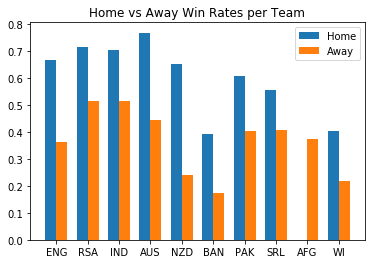

In [60]:
fig, ax = plt.subplots()
ind = np.arange(10)
width = 0.35
p1 = ax.bar(ind , homeWinRates, width)
p2 = ax.bar(ind + width, awayWinRates, width)

ax.set_title('Home vs Away Win Rates per Team')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(teamAbbrev)

ax.legend((p1[0], p2[0]), ('Home', 'Away'));